In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

In [2]:
# load predicted values from the previous 6-fold cross-validation as df
bert_1 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_h_bert_ds6_fold1_results.csv')
bert_2 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_h_bert_ds5_fold2_results.csv')
bert_3 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_h_bert_ds4_fold3_results.csv')
bert_4 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_h_bert_ds3_fold4_results.csv')
bert_5 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_h_bert_ds2_fold5_results.csv')
bert_6 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_h_bert_ds1_fold6_results.csv')
# concat data
bert = pd.concat((bert_1, bert_2, bert_3, bert_4, bert_5, bert_6), axis=0)
#bert = bert.rename({'3': 'SMILES', '4':'Mol_No', '5': 'actual', '6':'predict'}, axis='columns')

In [3]:
bert_1

,Unnamed: 0,smiles,actual,predict
0,0,SC#N,10.9,6.721265
1,1,CC1CCCC1,1.0,2.252125
2,2,CCCCC(CC)CNCC(CC)CCCC,3.2,3.982227
3,3,CCCCCCCCCC,0.0,0.439862
4,4,O=C(CCCCCCCCC(=O)OCc1ccccc1)OCc2ccccc2,5.5,5.696132
...,...,...,...,...
192,192,CC=CCC#N,5.1,5.690761
193,193,CCCCOC(C)=O,6.3,6.363953
194,194,CC(C)=C=O,4.8,6.658949
195,195,Fc1cccc(F)c1C#N,3.2,2.822671


In [4]:
bert["index"] = bert["smiles"].str.find('c1ccnnc1')

In [5]:
bert.loc[lambda bert: bert["index"] == 0]

,Unnamed: 0,smiles,actual,predict,index
73,73,c1ccnnc1,11.7,6.818827,0


In [6]:
# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(bert['actual'], bert['predict']))

#RMSEs
print(math.sqrt(mean_squared_error(bert['actual'], bert['predict'])))

# R^2 Coefficient of Determination
print(r2_score(bert['actual'], bert['predict']))

2.0336101049306845
3.1990556494228293
0.6168435033906736


In [7]:
len(bert)

1183

In [8]:
# calculate the residual value for each molecule
bert['residual']= bert['predict']-bert['actual']

In [9]:
# calculate standardised deviation of the residuals (sdr) of the dataset
# equations used: sdr = sqrt((sum((residual)**2))/(n-2))
sdr = np.sqrt((bert['residual']**2).sum()/(len(bert)-2))
sdr

3.2017632721245652

In [10]:
# calculate how many sdr each molecule's predicted value is away from the exp value 
bert['std_residual'] = bert['residual']/sdr
bert['std_residual']

0     -1.305136
1      0.391074
2      0.244311
3      0.137381
4      0.061257
         ...   
193    0.296929
194   -0.247751
195   -1.072045
196    0.129384
197   -0.679482
Name: std_residual, Length: 1183, dtype: float64

In [11]:
# n is 2 or 3. Points 2 or 3 sdr away from the prediction line are likely to be outliers
n = 3
bert_outliers = bert.loc[abs(bert['std_residual']) > n]
bert_outliers

,Unnamed: 0,smiles,actual,predict,index,residual,std_residual
6,6,OCCC#N,17.6,6.049999,-1,-11.550001,-3.607388
24,24,NCCO,21.0,6.498917,-1,-14.501083,-4.529093
70,70,CC=NO,20.2,8.302810,-1,-11.897190,-3.715824
185,185,O=C=S,0.0,11.336613,-1,11.336613,3.540741
5,5,COO,30.0,13.013327,-1,-16.986673,-5.305412
81,81,CN[C@@H](C)[C@H](O)c1ccccc1,24.1,11.785397,-1,-12.314603,-3.846194
95,95,CO,22.3,10.867623,-1,-11.432377,-3.570650
104,104,COCO,18.5,7.883553,-1,-10.616447,-3.315813
6,6,CC1=CN([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)C(=O)...,32.8,17.090920,-1,-15.709080,-4.906384
10,10,OC(F)(C(F)F)C(F)(F)F,14.7,5.002471,-1,-9.697529,-3.028809


In [12]:
# Set the default text font size
plt.rc('font', size=22)

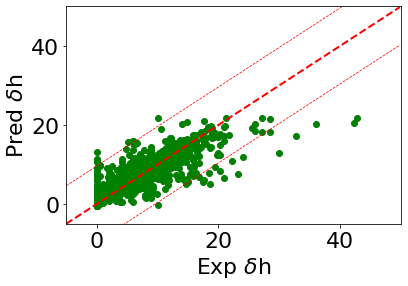

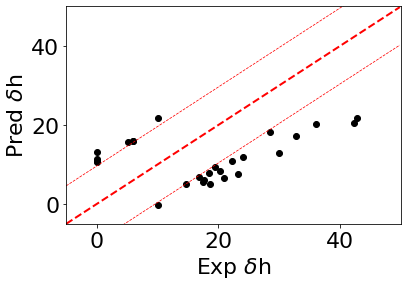

In [13]:
plt.figure(2)

# plot of exp vs pred of all molecules in the dataset
# The thick red lines indicate ideal agreement between the predicted and experimental values. 
# The dashed red lines indicate 3 srd (n=3) away from the ideal agreement. 
ln = np.arange(-5, 50, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert['actual'], y=bert['predict'], color='green')
plt.xlabel('Exp $\delta$h')
plt.ylabel('Pred $\delta$h')
plt.xlim([-5,50])
plt.ylim([-5,50])
plt.show()

# Plot of the outliers identified 
# check visually to confirm they are on or beyond 3 srd
ln = np.arange(-5, 50, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert_outliers['actual'], y=bert_outliers['predict'], color='black')
plt.xlabel('Exp $\delta$h')
plt.ylabel('Pred $\delta$h')
plt.xlim([-5,50])
plt.ylim([-5,50])
plt.show()

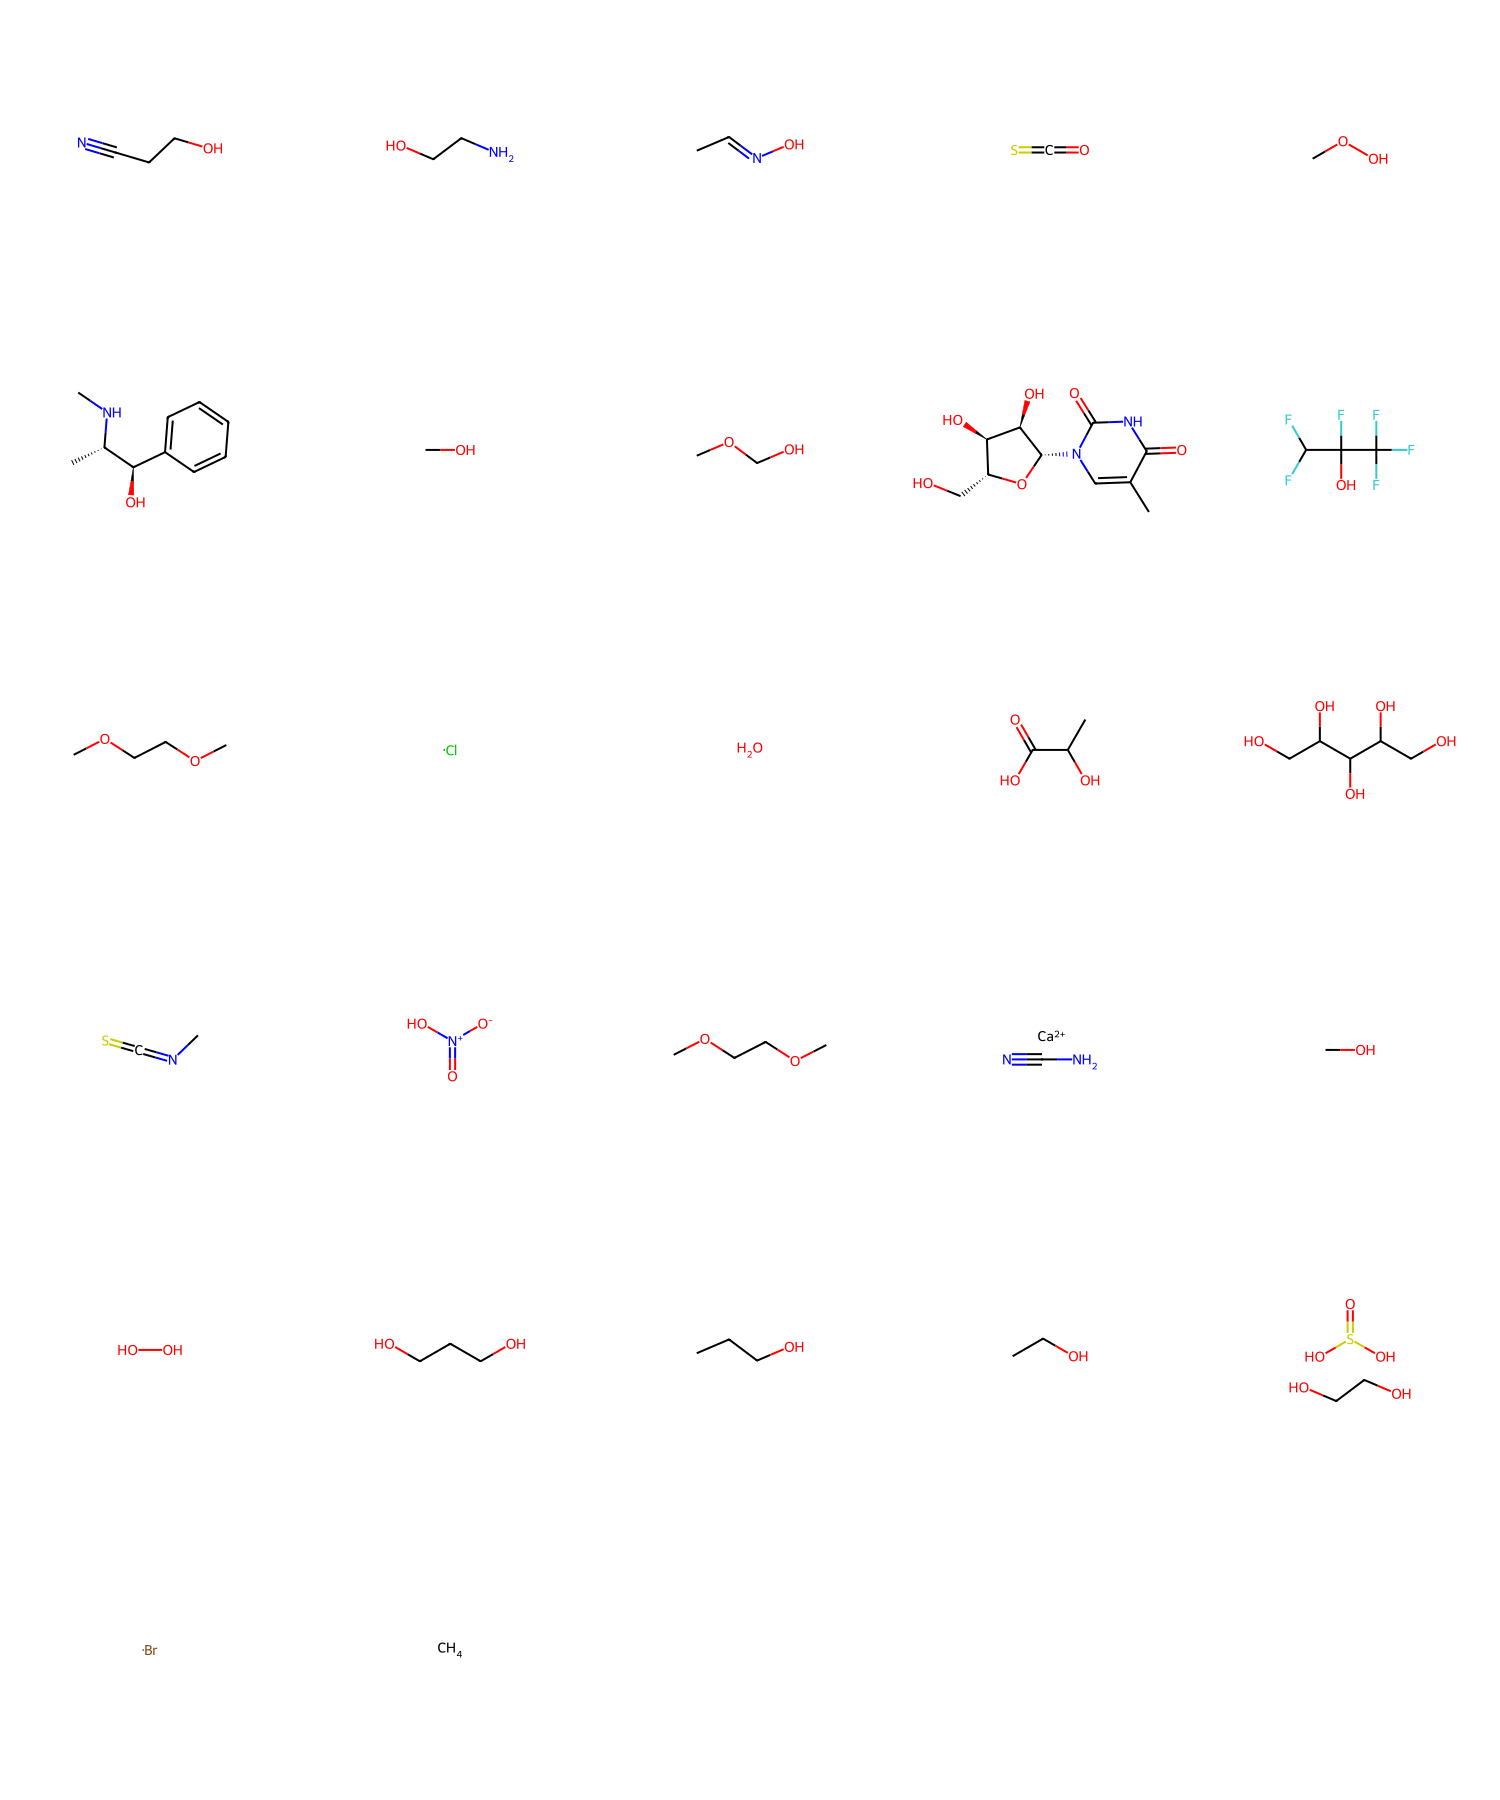

In [14]:
# draw n=3 outlier structure
outliners = [Chem.MolFromSmiles(x) for x in bert_outliers['smiles']]
Draw.MolsToGridImage(outliners, subImgSize=(300,300), molsPerRow=5, maxMols=50)

In [15]:
bert_outliers.to_csv('bert_h_outliers3.csv')

In [16]:
# n is 2 or 3. Points 2 or 3 sdr away from the prediction line are likely to be outliers
n = 2
bert_outliers2 = bert.loc[abs(bert['std_residual']) > n]
bert_outliers2

,Unnamed: 0,smiles,actual,predict,index,residual,std_residual
6,6,OCCC#N,17.6,6.049999,-1,-11.550001,-3.607388
24,24,NCCO,21.0,6.498917,-1,-14.501083,-4.529093
70,70,CC=NO,20.2,8.302810,-1,-11.897190,-3.715824
134,134,S=C=S,0.6,9.518504,-1,8.918504,2.785498
173,173,CCCCO,15.8,7.040967,-1,-8.759033,-2.735690
...,...,...,...,...,...,...,...
75,75,OCCN1CCCC1=O,15.7,8.913386,-1,-6.786614,-2.119649
79,79,BrC#N,0.0,6.453456,-1,6.453456,2.015594
107,107,C1CCCCCCCCCCC1,0.0,7.269525,-1,7.269525,2.270475
172,172,CCN=C=S,9.0,1.482540,-1,-7.517460,-2.347912


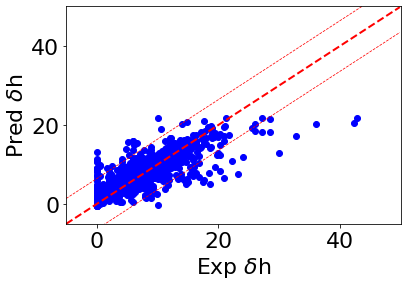

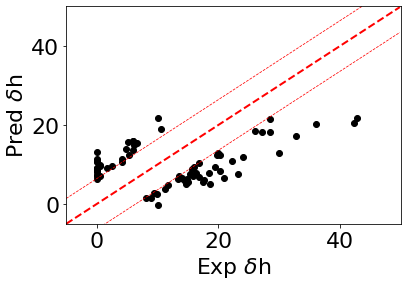

In [17]:
plt.figure(2)

# plot of exp vs pred of all molecules in the dataset
# The thick red lines indicate ideal agreement between the predicted and experimental values. 
# The dashed red lines indicate 2 srd (n=2) away from the ideal agreement. 
ln = np.arange(-5, 50, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert['actual'], y=bert['predict'], color='blue')
plt.xlabel('Exp $\delta$h')
plt.ylabel('Pred $\delta$h')
plt.xlim([-5,50])
plt.ylim([-5,50])
plt.show()

# Plot of the outliers identified 
# check visually to confirm they are on or beyond 2 srd
ln = np.arange(-5, 50, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert_outliers2['actual'], y=bert_outliers2['predict'], color='black')
plt.xlabel('Exp $\delta$h')
plt.ylabel('Pred $\delta$h')
plt.xlim([-5,50])
plt.ylim([-5,50])
plt.show()

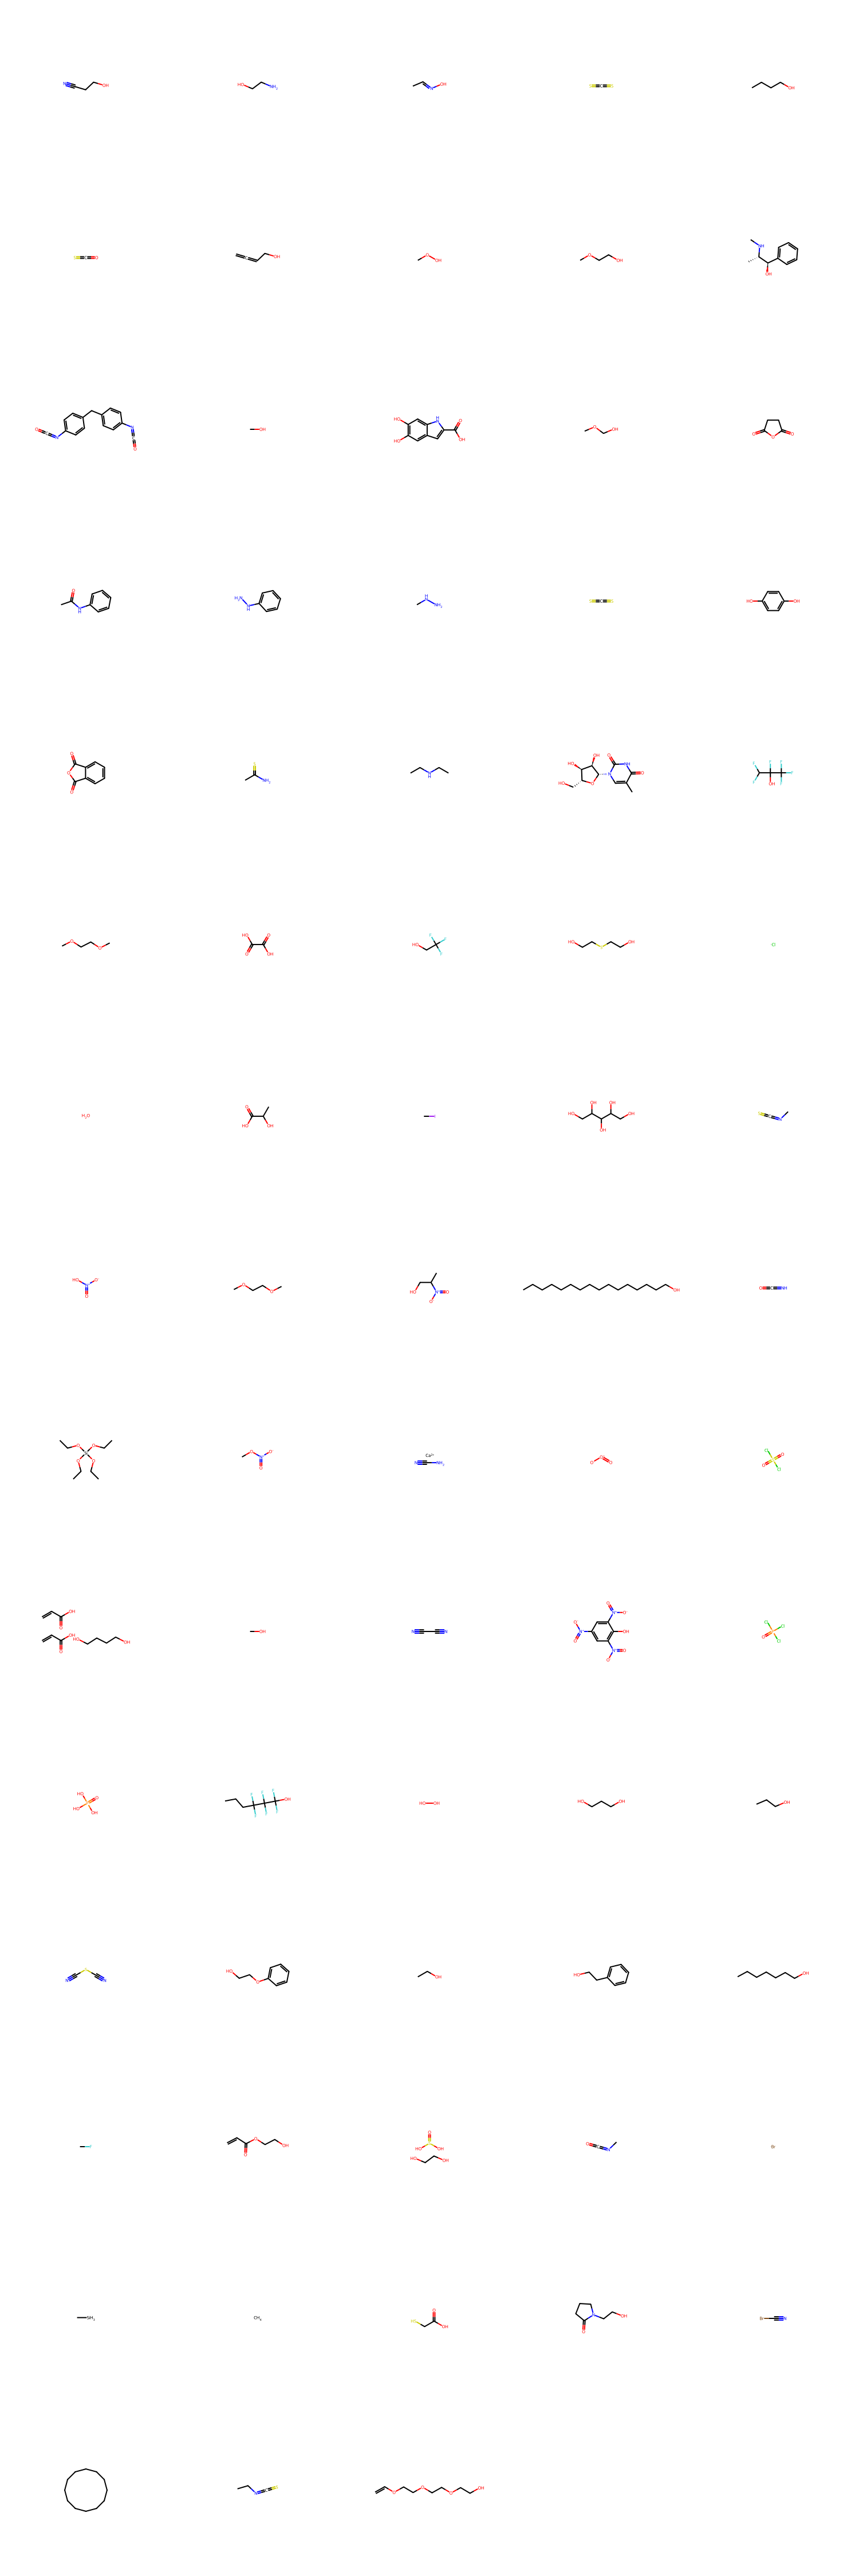

In [18]:
# draw n=2 outlier structure
outliners2 = [Chem.MolFromSmiles(x) for x in bert_outliers2['smiles']]
Draw.MolsToGridImage(outliners2, subImgSize=(300,300), molsPerRow=5, maxMols=100)

In [19]:
# save outliers (n=2) info to a csv file
bert_outliers2.to_csv('bert_h_outliers2.csv')

In [20]:
from rdkit.Chem import Descriptors
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')
mol_smiles = gpHSP_data['SMILES']

# calculate molecular weight of the full dataset
molwt = [(Descriptors.ExactMolWt(Chem.MolFromSmiles(x))) for x in gpHSP_data['SMILES']]
np_molwt = np.asarray(molwt)

# calculate molecular weight of outliers
molwt_outliers2 = [(Descriptors.ExactMolWt(Chem.MolFromSmiles(x))) for x in bert_outliers2['smiles']]
np_molwt_outliers2 = np.asarray(molwt_outliers2)

# Compare average molecular weight for full data and outliers
print(np.average(np_molwt))
print(np.average(np_molwt_outliers2))

131.2953603288794
103.18094194981069


In [24]:
# Set the default text font size
plt.rc('font', size=16)

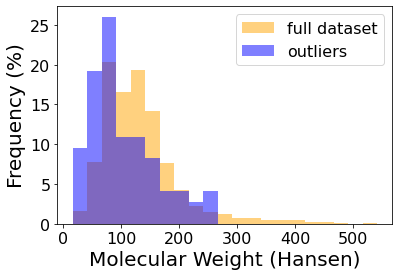

In [25]:
# plot molecular weight distribution for the full dataset and the outliers
bin_width = 25
df = pd.DataFrame(np_molwt, columns = ["full dataset"])
df2 = pd.DataFrame(np_molwt_outliers2, columns = ["outliers"])
ax = df.plot.hist(bins=(np.arange(min(molwt), max(molwt)+bin_width, bin_width)), alpha=0.5, color='orange', weights=np.ones_like(df.index) *100/ len(df))
df2.plot(kind='hist', bins=(np.arange(min(molwt_outliers2), max(molwt_outliers2)+bin_width, bin_width)), alpha=0.5, color='blue', weights=np.ones_like(df2.index) *100 /len(df2), ax=ax)
ax.set_xlabel("Molecular Weight (Hansen)", size=20)
ax.set_ylabel("Frequency (%)", size=20)
plt.show()